In [1]:
import numpy as np
import dedalus.public as d3

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# Numerics Parameters
L = 2*np.pi*15; Lx = L
log_n = 7; Nx = 2**log_n
dtype = np.complex128

# Bases
coords = d3.CartesianCoordinates('x')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.ComplexFourier(coords['x'], size=Nx, bounds=(0, Lx))

In [3]:
# Fields
omega = dist.Field()
kx = dist.Field(name='kx')
ky = dist.Field(name='ky')

q1 = dist.Field(bases=(xbasis) )
q2 = dist.Field(bases=(xbasis) )
psi1 = dist.Field(bases=(xbasis) )
psi2 = dist.Field(bases=(xbasis) )

tau_psi1 = dist.Field()

# Substitutions
dx = lambda A: d3.Differentiate(A, coords['x'])
# dx = lambda A: 1j*kx*A
dy = lambda A: 1j*ky*A
dt = lambda A: -1j*omega*A

lap = lambda A: dx(dx(A))+dy(dy(A))

y = dist.local_grids(xbasis)

2023-08-29 07:56:44,032 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s


/tmp/ipykernel_3291/2596756572.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  xi = 1/(2*np.sqrt(gam))


(513,)
2023-08-29 07:56:45,531 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+01/s
(513,)
2023-08-29 07:56:46,609 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s
(513,)


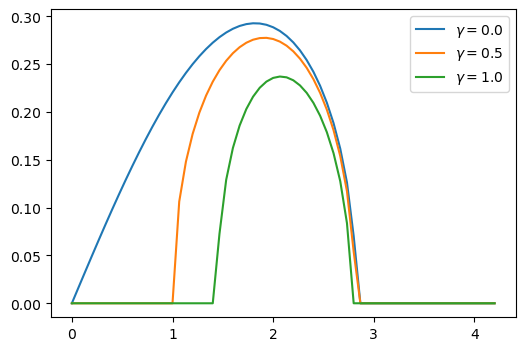

In [4]:
fig=plt.figure(1, figsize=(6,4))
gam_ary = [0,1/2,1]

for gam in gam_ary:
    xi = 1/(2*np.sqrt(gam))
    
    # Problem
    problem = d3.EVP([q1, q2, psi1, psi2, tau_psi1], eigenvalue=omega, namespace=locals())
    problem.add_equation("dt(q1)+dx(q1)+(xi**(-2)+8)*dx(psi1) = 0")
    problem.add_equation("dt(q2)-dx(q2)+(xi**(-2)-8)*dx(psi2) = 0")
    problem.add_equation("lap(psi1)+4*(psi2-psi1)-q1+tau_psi1=0")
    problem.add_equation("lap(psi2)+4*(psi1-psi2)-q2=0")
    problem.add_equation("integ(psi1) = 0")
    
    # Solver
    # kx['g'] = 3
    ky['g'] = 0

    solver = problem.build_solver()
    solver.solve_dense(solver.subproblems[0])
    evals = solver.eigenvalues
    print(evals.shape)
    
    # PLot
    t_plot = np.insert(np.imag(evals)[4:Nx*2:4], [0], [0])
    kx_plot = xbasis.wavenumbers[0:t_plot.shape[0]];

    plt.figure(1)
    
    plt.plot(kx_plot,t_plot/4,'-', label='$\gamma=%.1f$'%gam)
    

plt.figure(1)
plt.legend()

plt.savefig("figs/2Lay_linstab.pdf", bbox_inches='tight')
plt.show()